In [1]:
import os.path as osp
import pandas as pd
from tifffile import tifffile as tif
import numpy as np
from matplotlib import pyplot as plt
from einops import rearrange
import torch
from torchvision import transforms

In [2]:
# paths
data_path = '../../../../data'
csv_path = osp.join(data_path, 'image_series.csv')
series = pd.read_csv(csv_path)

s1_path = osp.join(data_path, 's1')  # contains VV and VH
s2_path = osp.join(data_path, 's2')  # contains LAI
s2m_path = osp.join(data_path, 's2-mask')

## Parse localization and coordinates on grids

In [4]:
grids = {}
i_m = 0
for line in series.itertuples():
    name = line[1]
    split = name.split('-')
    head, row, col = '-'.join(split[:5]), int(split[7]), int(split[8].split('.')[0])
    if head not in grids:
        grids[head] = np.zeros((33, 33), dtype=np.uint8)
    grids[head][row, col] = 1

## Get the 2 $\times$ 2 squares and save names in a csv

In [5]:
list_square = []

n_heads = len(grids)
for head_i, head in enumerate(grids):
    grid = grids[head]
    for i in range(0, 32):
        for j in range(0, 32):
            if grid[i, j] + grid[i+1, j] + grid[i, j+1] + grid[i+1, j+1] == 4:
                list_square.append([
                    f'{head}-0-0-{i}-{j}.tiff',
                    f'{head}-0-0-{i}-{j+1}.tiff',
                    f'{head}-0-0-{i+1}-{j}.tiff',
                    f'{head}-0-0-{i+1}-{j+1}.tiff',
                    
                    f'{head}-1-0-{i}-{j}.tiff',
                    f'{head}-1-0-{i}-{j+1}.tiff',
                    f'{head}-1-0-{i+1}-{j}.tiff',
                    f'{head}-1-0-{i+1}-{j+1}.tiff',
                    
                    f'{head}-2-0-{i}-{j}.tiff',
                    f'{head}-2-0-{i}-{j+1}.tiff',
                    f'{head}-2-0-{i+1}-{j}.tiff',
                    f'{head}-2-0-{i+1}-{j+1}.tiff',
                    ])
# save to csv
square_df = pd.DataFrame(list_square,
                         columns=['uleft0', 'uright0', 'bleft0', 'bright0',
                                  'uleft1', 'uright1', 'bleft1', 'bright1',
                                  'uleft2', 'uright2', 'bleft2', 'bright2'])
square_df.to_csv('square.csv', index=False)

## Read and transform the squares

In [6]:
def mask(img_mask):
    """Transform an S2 mask (values between 1 and 9) to float32 binary.

    It uses the simple filter:
    0, 1, 7, 8, 9 -> 0 (incorrect data)
    other -> 1 (correct data)
    """
    interm = np.where(img_mask < 2, 0.0, 1.0)
    return np.where(img_mask > 6, 0.0, interm)

### Read data

In [7]:
i_grid = 0
square_df = pd.read_csv('square.csv')
# shuffle
square_df = square_df.sample(frac=1).reset_index(drop=True)
grid_np = np.empty((0, 256, 256, 4))
for key in square_df.keys():
    sample = np.empty((256, 256, 0))
    for path in [s2_path, s2m_path, s1_path]:
        data = tif.imread(osp.join(path, square_df[key][i_grid]))
        if path == s2m_path:
            data = mask(data)
        if data.ndim == 2:
            data = data[..., None]
        sample = np.concatenate((sample, data), axis=2)
    sample = sample[None, ...]
    grid_np = np.concatenate((grid_np, sample), axis=0)
grid_np = rearrange(grid_np, '(time loc) h w c -> time loc h w c', time=3, loc=4)
grid_np = rearrange(grid_np, 'time (loc1 loc2) h w c -> time (loc1 w) (loc2 h) c',
                    loc1=2, loc2=2)
grid = torch.from_numpy(grid_np).float()
grid = rearrange(grid, 'time H W c -> time c H W')


### Visualize the data


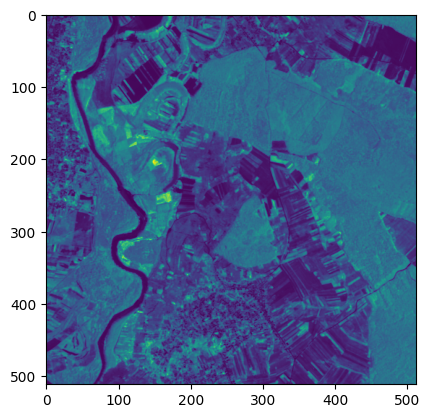

In [10]:
plt.imshow(grid_np[0, ..., 0])

### Apply transformation

Without zoom (random rotations)

theta = 51.421849470128215
theta = 0.488048330932046
theta = 69.88461699068978
theta = 37.46736700464503


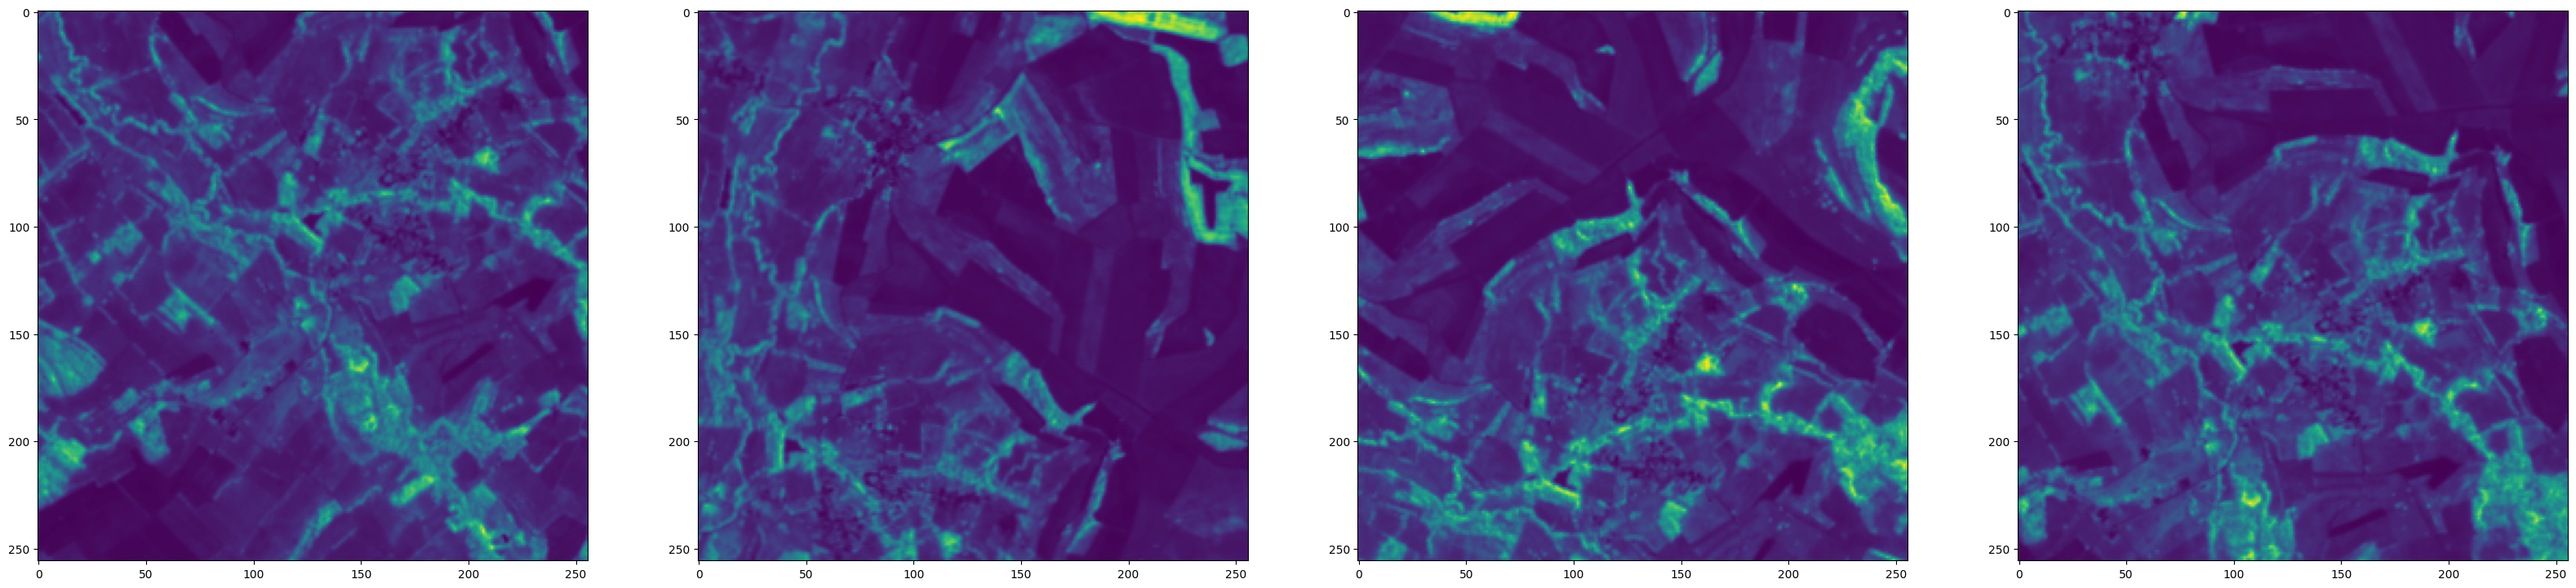

In [74]:
interpolation = transforms.InterpolationMode.BILINEAR

_, ax = plt.subplots(1, 4, figsize=(40, 10))

for i in range(4):

    theta = np.random.rand() * 90
    grid_r = transforms.functional.rotate(grid, theta, interpolation=interpolation,
                                        expand=True, fill=0.0)
    ext = len(grid_r[0, 0])
    x_min = int(256 * np.sin(np.deg2rad(theta)))
    x_max = ext - 256 - x_min
    x = int(np.random.rand() * (x_max - x_min) + x_min)
    y_min = int(256 * np.cos(np.deg2rad(theta)))
    y_max = ext - 256 - y_min
    y = int(np.random.rand() * (y_max - y_min) + y_min)
    data = grid_r[:, :, y:y+256, x:x+256]
    # plot
    data_np = data.numpy().transpose(0, 2, 3, 1)
    ax[i].imshow(data_np[0, ..., 0])
    print('theta =', theta)

plt.plot();


With zoom

theta = 45 zoom = 1
theta = 45 zoom = 1.3
theta = 45 zoom = 0.7
theta = 30 zoom = 1
theta = 60 zoom = 1
theta = 80 zoom = 0.8
theta = 80 zoom = 1.2


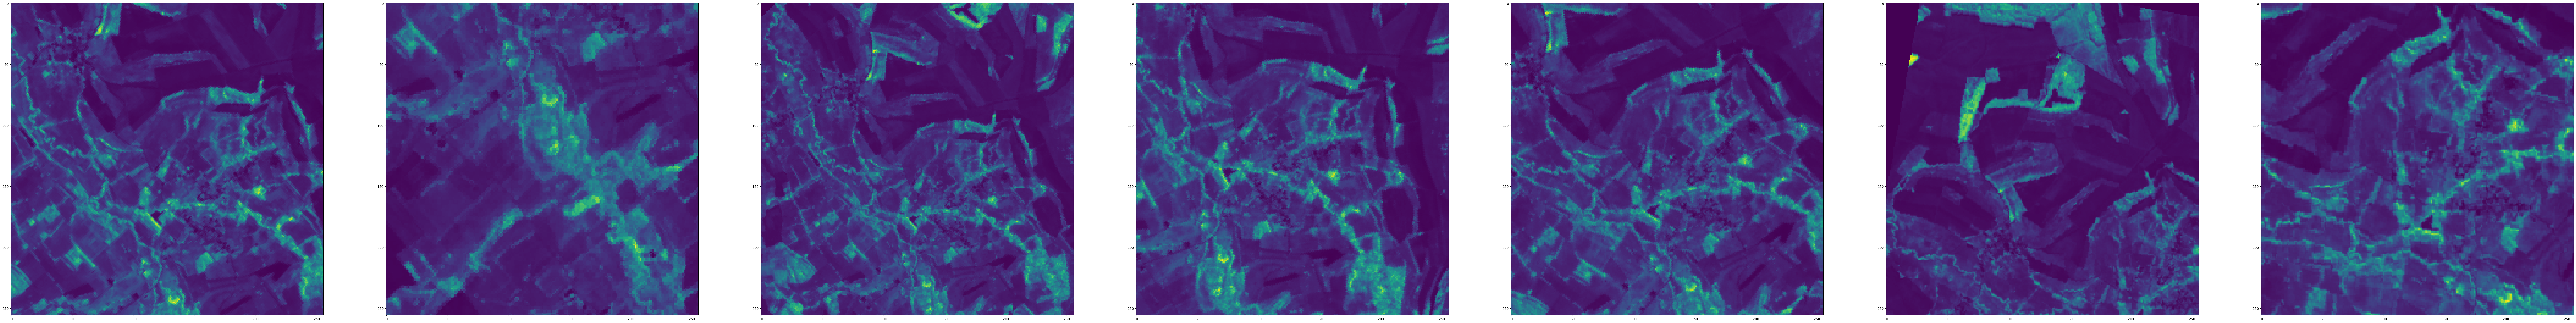

In [108]:
interpolation = transforms.InterpolationMode.NEAREST

fig, ax = plt.subplots(1, 7, figsize=(140, 20))

for i, (theta, zoom) in enumerate([(0, 1), (0, 1.3), (0, 0.7), (30, 1), (60, 1),
                                   (80, 0.8), (80, 1.2)]):
    # zoom = 1 + (np.random.rand() - 0.5) * 0.6
    size = int(256 * (2-zoom))

    # theta = np.random.rand() * 90
    grid_r = transforms.functional.rotate(grid, theta, interpolation=interpolation,
                                        expand=True, fill=0.0)
    ext = len(grid_r[0, 0])
    x_min = min(256, int(size * np.sin(np.deg2rad(theta))))
    x_max = ext - size - x_min
    x = int(np.random.rand() * (x_max - x_min) + x_min)
    y = int(np.random.rand() * (x_max - x_min) + x_min)
    data = grid_r[:, :, y:y+size, x:x+size]
    # Resize to 256x256
    data = transforms.functional.resize(data, (256, 256), interpolation=interpolation)
    # plot
    data_np = data.numpy().transpose(0, 2, 3, 1)
    ax[i].imshow(data_np[0, ..., 0])
    print('theta =', theta, 'zoom =', zoom)

plt.plot();